In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from math import comb

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [2]:
# ---------- Theoretical Δ(p) ----------

def delta_best_of_k(p, k):
    """
    Δ(p) for idealised 'best-of-k':
    success if ANY of the k samples is correct.
    """
    p = np.asarray(p, dtype=float)
    return 1 - (1 - p)**k - p

def p_sc_majority(p, k):
    """
    Success prob for majority vote over k samples
    (k should be odd).
    """
    m = k // 2 + 1  # majority threshold
    return sum(comb(k, i) * p**i * (1 - p)**(k - i) for i in range(m, k + 1))

def delta_majority(p, k):
    """
    Δ(p) for majority-vote self-consistency.
    """
    p = np.asarray(p, dtype=float)
    p_sc = np.vectorize(p_sc_majority)(p, k)
    return p_sc - p


In [3]:
def compute_global_uplift(results, n_bins=15):
    """
    Compute uplift (SC - greedy accuracy) as a function of predicted success prob p,
    using the FULL dataset (no routing subsets).

    Assumes:
      - results['all_greedy'] and results['all_sc'] exist
      - both have:
          - 'predicted_success_prob'
          - 'is_correct'
      - indices are aligned across strategies.
    """
    greedy_df = results["all_greedy"].copy()
    sc_df     = results["all_sc"].copy()
    
    assert greedy_df.index.equals(sc_df.index), "Greedy and SC indices must align"
    
    # Global binning based on greedy predicted p
    bin_labels = pd.qcut(
        greedy_df["predicted_success_prob"],
        q=n_bins,
        duplicates="drop"
    )
    
    merged = pd.DataFrame({
        "prob_bin": bin_labels,
        "predicted_success_prob": greedy_df["predicted_success_prob"],
        "greedy_correct": greedy_df["is_correct"].astype(int),
        "sc_correct":     sc_df["is_correct"].astype(int),
    })
    
    bin_stats = (
        merged
        .groupby("prob_bin", observed=False)
        .agg(
            count            = ("predicted_success_prob", "size"),
            bin_min          = ("predicted_success_prob", "min"),
            bin_max          = ("predicted_success_prob", "max"),
            bin_mean         = ("predicted_success_prob", "mean"),
            greedy_accuracy  = ("greedy_correct", "mean"),
            sc_accuracy      = ("sc_correct", "mean"),
        )
        .reset_index()
    )
    
    bin_stats["uplift"] = bin_stats["sc_accuracy"] - bin_stats["greedy_accuracy"]
    
    return bin_stats, bin_labels


In [4]:
def plot_uplift_with_theory(bin_stats, k=5, dataset_name="DATASET"):
    """
    Plot empirical uplift vs p, and overlay theoretical Δ(p) curves.
    """
    p_grid = np.linspace(0.0, 1.0, 500)
    delta_bok = delta_best_of_k(p_grid, k)
    delta_maj = delta_majority(p_grid, k)

    fig, ax = plt.subplots(figsize=(14, 7))

    # Empirical uplift from data
    ax.plot(
        bin_stats["bin_mean"],
        bin_stats["uplift"],
        marker="o", linestyle="-", linewidth=2.5, markersize=7,
        label="Empirical uplift (SC - greedy)"
    )

    # Theoretical curves (optional; toggle if you only want one)
    ax.plot(
        p_grid, delta_bok,
        linestyle="--", linewidth=2,
        label=f"Theory Δ(p) best-of-{k}"
    )
    ax.plot(
        p_grid, delta_maj,
        linestyle=":", linewidth=2,
        label=f"Theory Δ(p) majority-{k}"
    )

    ax.axhline(0.0, color="black", linestyle="--", linewidth=1.5, alpha=0.6)

    ax.set_xlabel("Predicted success probability $\hat p$", fontsize=14, fontweight="bold")
    ax.set_ylabel("Uplift  (SC accuracy − greedy accuracy)", fontsize=14, fontweight="bold")
    ax.set_title(
        f"{dataset_name}: SC uplift vs predicted probability\n"
        "Global (no routing policy)",
        fontsize=15, fontweight="bold"
    )
    ax.set_xlim(0.0, 1.0)
    ax.grid(alpha=0.3, linestyle=":", linewidth=1)
    ax.legend(fontsize=11, framealpha=0.9)
    
    # Optional shading: low / mid / high p regions
    ax.axvspan(0.0, 0.3, alpha=0.05, color="red",   label="_low $\hat p$ (hard)")
    ax.axvspan(0.3, 0.7, alpha=0.05, color="yellow",label="_medium $\hat p$ (uncertain)")
    ax.axvspan(0.7, 1.0, alpha=0.05, color="green", label="_high $\hat p$ (easy)")
    
    plt.tight_layout()
    plt.show()


<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:45: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:47: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:45: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:47: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3675232/3556240748.py:33: SyntaxWarning: invalid escape sequence '\h'
  ax.set_xlabel("Predicted success probability $\hat p$", fontsize=14, fontweight="bold")
/tmp/ipykernel_3675232/3556240748.py:45: SyntaxWarning: invalid escape sequence '\h'
  ax.axvspan(0.0, 0.3, alpha=0.05, color="red",   label="_low $\hat p$ (hard)")
/tmp/ipykernel_3675232/3556240748.py:46: SyntaxWarning: invalid escape sequence '\h'
  ax.axvspan(0.3, 0.7, alpha=0.05, color="yellow",label="_medium $\hat p$ (uncertain)")
/tmp/ipykernel_3675232/3556240748.py:47: SyntaxWarning: invalid escape sequence

In [5]:
def compute_routing_distribution(results, bin_labels, strategies, sc_flag_col="used_sc"):
    """
    For each routing strategy, compute in each p-bin:
      - fraction of questions routed to SC
      - (optional) count of questions

    Assumes:
      - results[strategy] shares the same indices as results['all_greedy']
      - each strategy df has boolean column sc_flag_col indicating SC vs greedy.
    """
    dist = {}
    
    for strategy in strategies:
        df = results[strategy]
        if sc_flag_col not in df.columns:
            print(f"⚠️  Strategy '{strategy}' missing column '{sc_flag_col}', skipping.")
            continue
        
        merged = pd.DataFrame({
            "prob_bin": bin_labels,
            "used_sc":  df[sc_flag_col].astype(bool)
        })
        
        bin_stats = (
            merged
            .groupby("prob_bin", observed=False)
            .agg(
                frac_sc=("used_sc", "mean"),
                count=("used_sc", "size")
            )
            .reset_index()
        )
        
        # Add bin midpoints for plotting
        bin_stats["bin_mean"] = (
            bin_stats["prob_bin"]
            .apply(lambda c: (c.left + c.right) / 2.0)
        )
        
        dist[strategy] = bin_stats
    
    return dist


In [6]:
def plot_routing_distribution(dist, dataset_name="DATASET"):
    """
    Plot, for each strategy, what fraction of questions in each p-bin
    are given SC.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    style_map = {
        'probe_quantile_bottom_10pct': {'color': '#1976D2', 'marker': 'o', 'label': 'Bottom 10% Quantile'},
        'probe_quantile_bottom_30pct': {'color': '#2E7D32', 'marker': 's', 'label': 'Bottom 30% Quantile'},
        'probe_threshold_0.50':        {'color': '#D32F2F', 'marker': '^', 'label': 'Threshold 0.50'},
        'random_30pct':                {'color': '#C096D8B8','marker': 'D', 'label': 'Random 30%'},
    }

    for strategy, bin_stats in dist.items():
        style = style_map.get(strategy, {"color": None, "marker": "o", "label": strategy})
        ax.plot(
            bin_stats["bin_mean"],
            bin_stats["frac_sc"],
            marker=style["marker"], linewidth=2.5, markersize=7,
            label=style["label"],
            alpha=0.9,
            color=style["color"]
        )
    
    ax.set_xlabel("Predicted success probability $\hat p$", fontsize=14, fontweight="bold")
    ax.set_ylabel("Fraction of questions routed to SC", fontsize=14, fontweight="bold")
    ax.set_title(
        f"{dataset_name}: where routing strategies spend compute",
        fontsize=15, fontweight="bold"
    )
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.grid(alpha=0.3, linestyle=":", linewidth=1)
    ax.legend(fontsize=11, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()


<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3675232/3939606775.py:26: SyntaxWarning: invalid escape sequence '\h'
  ax.set_xlabel("Predicted success probability $\hat p$", fontsize=14, fontweight="bold")


## Configuration

In [7]:
# Paths
# DATASET_NAME = "E2H-GSM8K"
# DATASET_NAME = "AIME_1983_2024"
DATASET_NAME = "GSM_HARD"
# DATASET_NAME = "AIME_2025"
MODEL_ALIAS = "Qwen2.5-Math-1.5B-Instruct"
GEN_STR = "max_3000_k_1_temp_0.0"
RESULTS_DIR = Path(f"../predicting_learnability/SELF_CONCISTENCY_EXPERIMENTS/{DATASET_NAME}/predicting_MATH_learnability_{MODEL_ALIAS}_{GEN_STR}_probe")

# Token pricing (USD per 1M tokens)
INPUT_TOKEN_PRICE = 0.25  # $0.25 per 1M input tokens
OUTPUT_TOKEN_PRICE = 1.00  # $1.00 per 1M output tokens

# Average prompt length (we'll estimate this)
AVG_PROMPT_TOKENS = 100  # typical math problem prompt

print(f"Loading results from: {RESULTS_DIR}")
print(f"\nPricing:")
print(f"  Input:  ${INPUT_TOKEN_PRICE:.2f} / 1M tokens")
print(f"  Output: ${OUTPUT_TOKEN_PRICE:.2f} / 1M tokens")

Loading results from: ../predicting_learnability/SELF_CONCISTENCY_EXPERIMENTS/GSM_HARD/predicting_MATH_learnability_Qwen2.5-Math-1.5B-Instruct_max_3000_k_1_temp_0.0_probe

Pricing:
  Input:  $0.25 / 1M tokens
  Output: $1.00 / 1M tokens


## Load Results

In [8]:
# Load all strategy results
strategies = ['all_greedy', 'all_sc', 'random_30pct', 'probe_threshold_0.50', 'probe_quantile_bottom_10pct', 'probe_quantile_bottom_30pct']

results = {}
for strategy in strategies:
    file_path = RESULTS_DIR / f"{MODEL_ALIAS}_{strategy}_results.parquet"
    if file_path.exists():
        df = pd.read_parquet(file_path)
        # df["predicted_success_prob"] = 1 / (1 + np.exp(-df["predicted_score"]))
        df["predicted_success_prob"] = df["predicted_score"]
        results[strategy] = df
        print(f"✓ Loaded {strategy}: {len(df)} questions, {df['total_tokens'].sum():,} total tokens")
    else:
        print(f"✗ Missing {strategy}")

print(f"\nLoaded {len(results)} strategies")

✓ Loaded all_greedy: 1319 questions, 696,695 total tokens
✓ Loaded all_sc: 1319 questions, 3,672,108 total tokens
✓ Loaded random_30pct: 1319 questions, 1,665,604 total tokens
✓ Loaded probe_threshold_0.50: 1319 questions, 3,127,686 total tokens
✓ Loaded probe_quantile_bottom_10pct: 1319 questions, 1,009,229 total tokens
✓ Loaded probe_quantile_bottom_30pct: 1319 questions, 1,675,504 total tokens

Loaded 6 strategies


<Axes: >

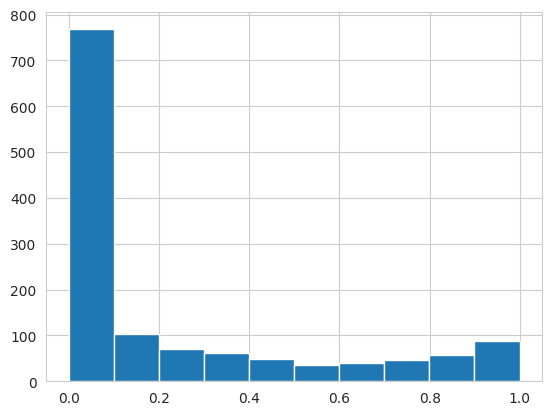

In [9]:
results["all_greedy"]["predicted_score"].hist()

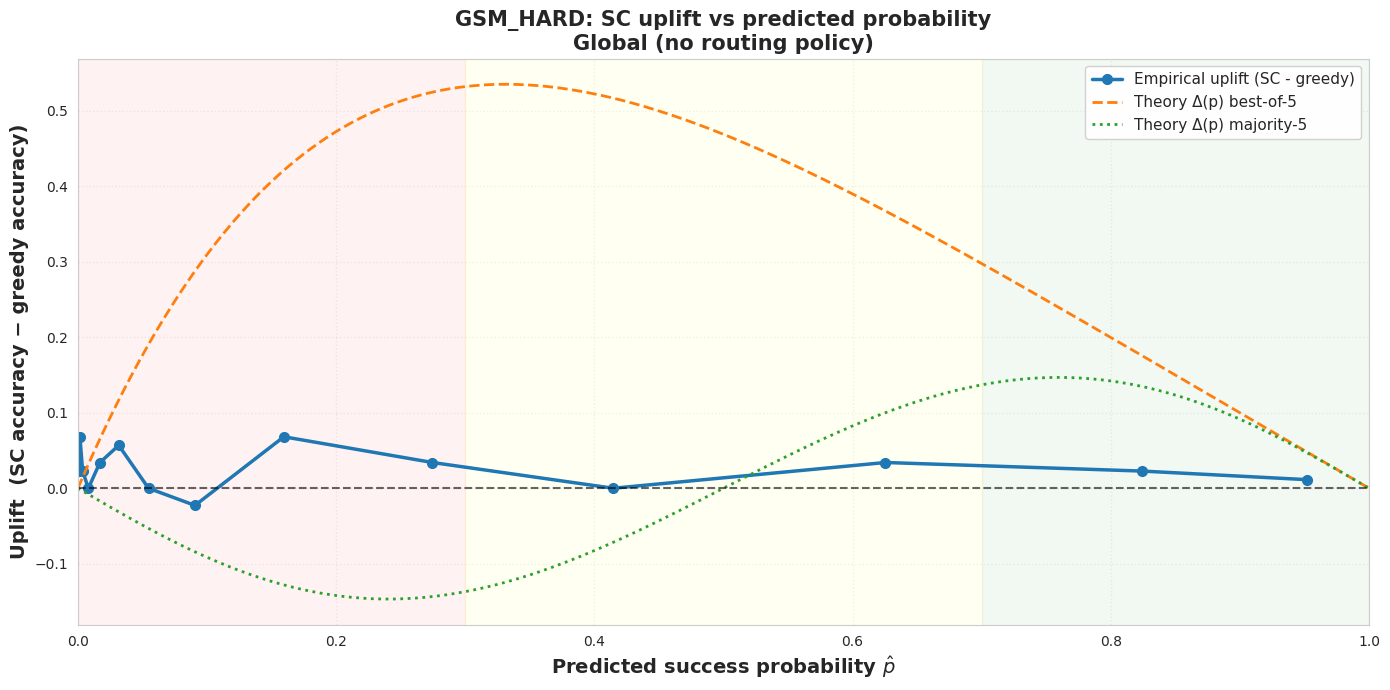

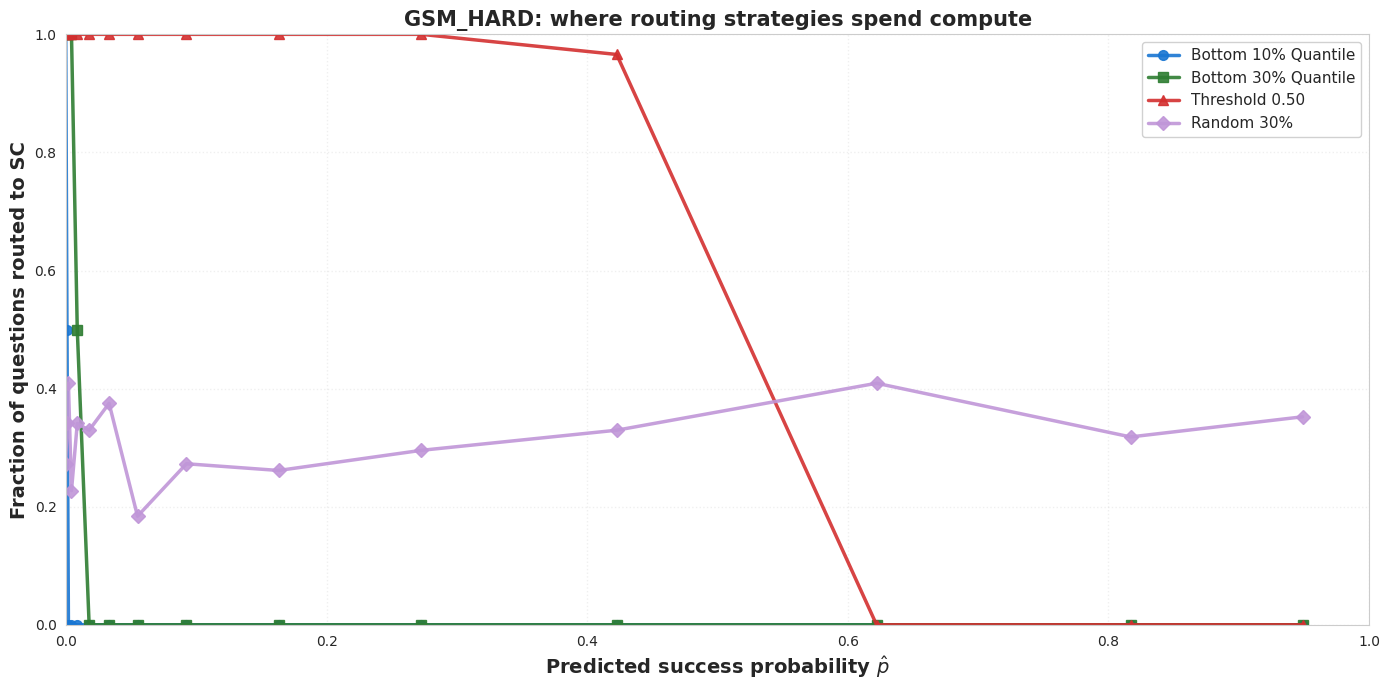

In [10]:
n_bins = 15
k_sc = 5

# 1) Global uplift curve
bin_stats, bin_labels = compute_global_uplift(results, n_bins=n_bins)
plot_uplift_with_theory(bin_stats, k=k_sc, dataset_name=DATASET_NAME)

# 2) Routing distributions (if you have a 'used_sc' flag per strategy)
strategies_to_compare = [
    "probe_quantile_bottom_10pct",
    "probe_quantile_bottom_30pct",
    "probe_threshold_0.50",
    "random_30pct",
]

routing_dist = compute_routing_distribution(results, bin_labels, strategies_to_compare,
                                            sc_flag_col="used_sc")
plot_routing_distribution(routing_dist, dataset_name=DATASET_NAME)